In [110]:
import sys
import os

# プロジェクトルートをsys.pathに追加
project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), "../../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH set to:", project_root)

PYTHONPATH set to: c:\Users\ndhaj\Desktop\TCI


In [111]:
# =============================
# [0] 共通Importと初期化
# =============================
from ptychoep.backend.backend import set_backend, np
set_backend("numpy")
from matplotlib import pyplot as plt
from ptychoep.ptycho.core import Ptycho
from ptychoep.utils.io_utils import load_data_image
from ptychoep.ptycho.aperture_utils import circular_aperture
from ptychoep.ptycho.scan_utils import generate_spiral_scan_positions, generate_centered_grid_positions
from ptychoep.ptycho.noise import GaussianNoise, PoissonNoise
from ptychoep.ptycho.visualize import compute_illumination
from ptychoep.rng.rng_utils import get_rng
from ptychoep.classic_engines.pie import PIE
from ptychoep.ptychoep.core import PtychoEP

# ------------------ 再構成対象データ準備 ------------------
image_size = 512
probe_size = 128
step = 10
num_scans = 19
jitter = 2

# オブジェクト
amp = np().asarray(load_data_image("cameraman.png"), dtype=np().complex64)
phase = np().asarray(load_data_image("eagle.png"), dtype=np().complex64)
obj = amp * np().exp(1j * np().pi/2 * phase)

# 初期プローブ
probe_gt = np().array(load_data_image("probe.png") , dtype=np().complex64)
probe_init = np().array(load_data_image("probe_init.png"), dtype=np().complex64)

# スキャン座標
positions = generate_centered_grid_positions(
    image_size=image_size,
    probe_size=probe_size,
    step=step,
    num_points_y=num_scans,
    num_points_x=num_scans,
    jitter=jitter,
    seed=90
)
data_seed = 124
# Ptychoオブジェクト
ptycho = Ptycho()
ptycho.set_object(obj)
ptycho.set_probe(probe_gt)
ptycho.forward_and_set_diffraction(positions)
ptycho.sort_diffraction_data()
scale = 3000
var = 1e-3
GaussianNoise(var = var, seed = data_seed) @ ptycho
print(f" {len(ptycho._diff_data)}\n Noise Stats : {ptycho.noise_stats}")

 361
 Noise Stats : {'type': 'Gaussian', 'var': 0.001, 'snr_mean_db': 3.7920875549316406}


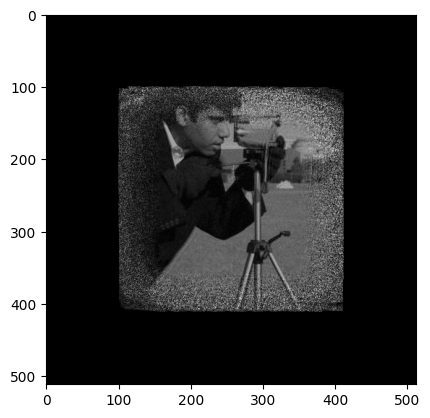

In [112]:
from ptychoep.ptychoep.core import PtychoEP

ep_list = []
def record_callback(it, err, current_obj):
        ep_list.append(err)

engine = PtychoEP(ptycho = ptycho,
                  damping = 0.5,
                  seed = 1,
                  callback = record_callback)
result_ep = engine.run(n_iter = 200)
plt.imshow(np().abs(result_ep[0]), cmap = "gray")

In [113]:
def phase_align(x_est, x_true):
    inner_product = np().vdot(x_true, x_est)
    phase = np().angle(inner_product)
    return x_est * np().exp(-1j * phase)

reconstruction = result_ep[0]
ground_truth = obj
reconstruction_phase_aligned = phase_align(reconstruction, ground_truth)
error_distribution = np().abs(reconstruction_phase_aligned - ground_truth)**2

rate = error_distribution* result_ep[1]

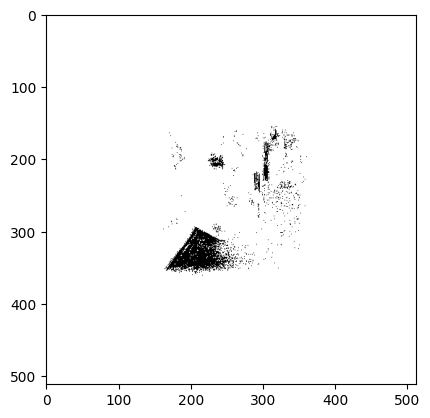

In [114]:
plt.imshow(rate < 10.0, cmap = "gray")

In [115]:
np().sum(rate[128:384, 128:384] < 4.0)/256**2

np.float64(0.8410491943359375)